In [1]:
#!pip install rich opendatasets  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import opendatasets as od
from rich.console import Console
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")
console = Console()

## Import the Data
### Download Data from Kaggle
   We will use the opendatasets library to download the dataset. We will be needing the Kaggle API key (a file called kaggle.json) to get authentication from your  kaggle profile account.

In [3]:
#Download the datasets from kaggle
dataset_url = "https://www.kaggle.com/ealaxi/paysim1"
od.download(dataset_url)
data_dir = "paysim1"
console.print('Folders:', '\t'.join(os.listdir()), style='bright_blue')
console.print("File name:",''.join(os.listdir(data_dir)), style='green')

Skipping, found downloaded files in ".\paysim1" (use force=True to force download)


Folders: .ipynb_checkpoints     .jovianrc       Ebenezer_Durai Project_Notebook.ipynb   
Ebenezer_Durai_project_Report.docx      kaggle.json     paysim1 project1.pptx   
~$project1.pptx

File name: PS_20174392719_1491204439457_log.csv

In [4]:
df = pd.read_csv(r'paysim1\PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
console.print(f"[bold]Shape:[/] {df.shape}")
console.print(f"[bold]size:[/] {df.size:,}")

Shape: (6362620, 11)

size: 69,988,820

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## What does the columns mean

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Exploratory Data Analysis

In [7]:
#Check Null values
console.print('Check for Null values', style='bold underline bright_red')
console.print(f'[bold]Null Values: [green]{df.isnull().values.any()}[/]')
console.print(df.isnull().sum(), style='bold bright_black')

Check for Null values

Null Values: False

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

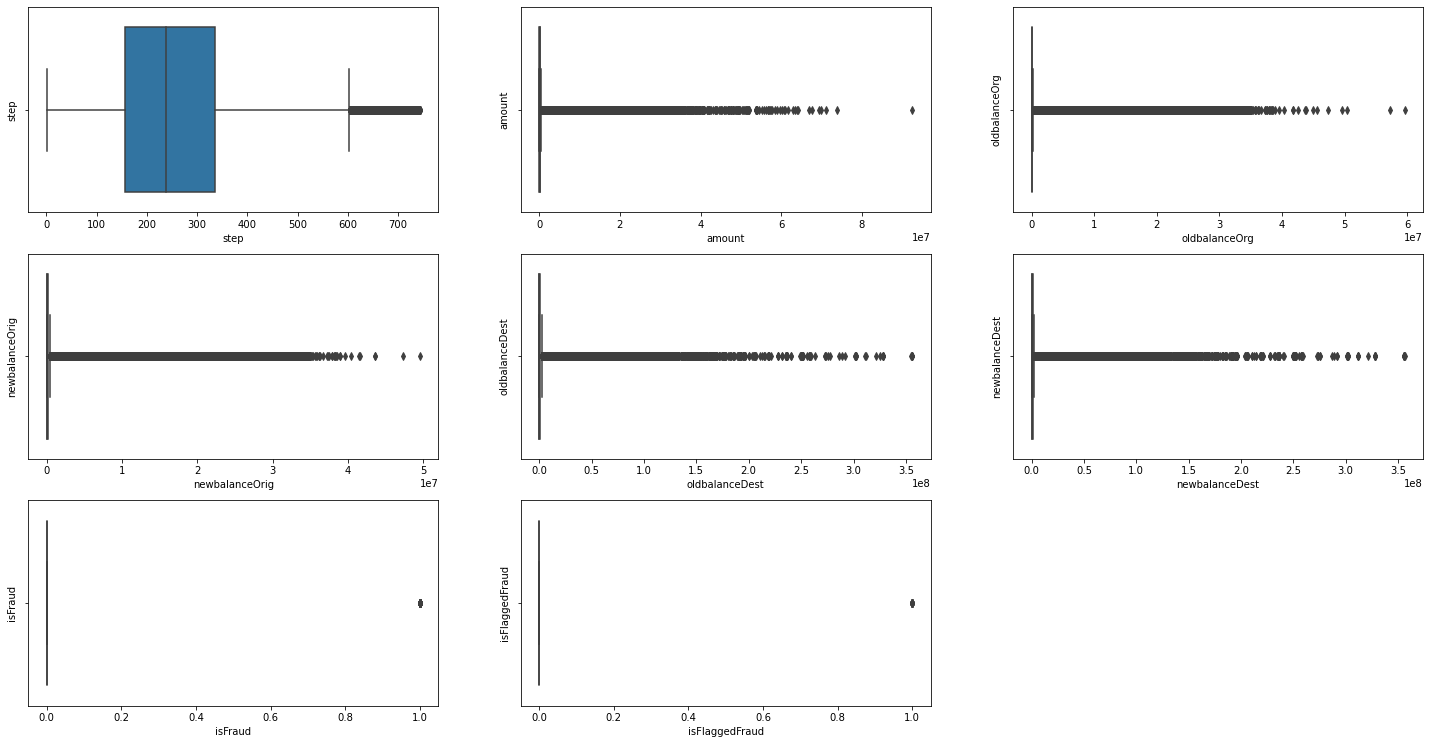

In [8]:
#checking for outliers
plt.figure(figsize=(25, 90))
for i, col in enumerate(df.select_dtypes(exclude='object').columns.values, 1):
    plt.subplot(20, 3, i)
    sns.boxplot(df[col])
    plt.ylabel(col)
plt.show()

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Distribution of Transaction type column

Transaction Types

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

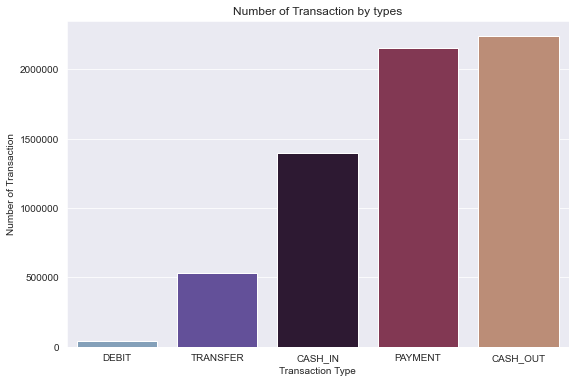

In [10]:
console.print('Transaction Types', style='bold')
console.print(df['type'].value_counts(), style='bold bright_black')
types_count = df['type'].value_counts().sort_values()
plt.figure(figsize=(9, 6))
sns.set_style('darkgrid')
sns.barplot(types_count.index, types_count, palette='twilight')
plt.title('Number of Transaction by types')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transaction')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

0    6354407
1       8213
Name: isFraud, dtype: int64

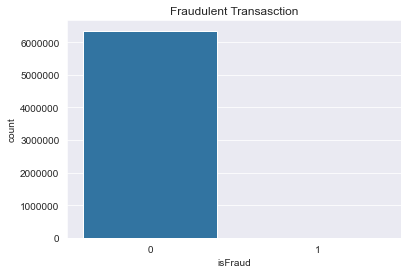

In [11]:
console.print(df['isFraud'].value_counts(), style='bold bright_black')
sns.countplot(df['isFraud'])
plt.title('Fraudulent Transasction')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

There is only 8213 Fraudulent transaction happened out of 63.6 lakhs transaction.

In [12]:
a = (8213/(df.shape[0]))*100
print ('The percentage of Fraud transactions is {}'.format(a))

The percentage of Fraud transactions is 0.12908204481801522


In [13]:
is_fraud = df.groupby(['type', 'isFraud'])['isFraud'].count()
console.print(is_fraud, style='bold')

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

From looking at the above table, the number of Fraudulent transaction occurred in only 'CASH_OUT' and 'TRANSFER' type transactions. So for our model training we will be taking datas from both these types.

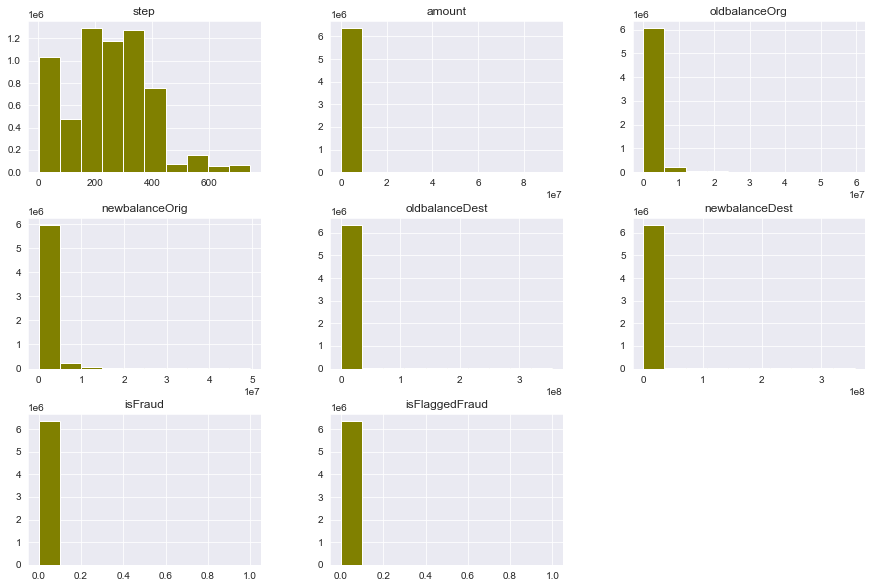

In [14]:
df.hist(figsize=(15, 10), color='olive')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [15]:
df_corr = df.corr()
df_corr

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


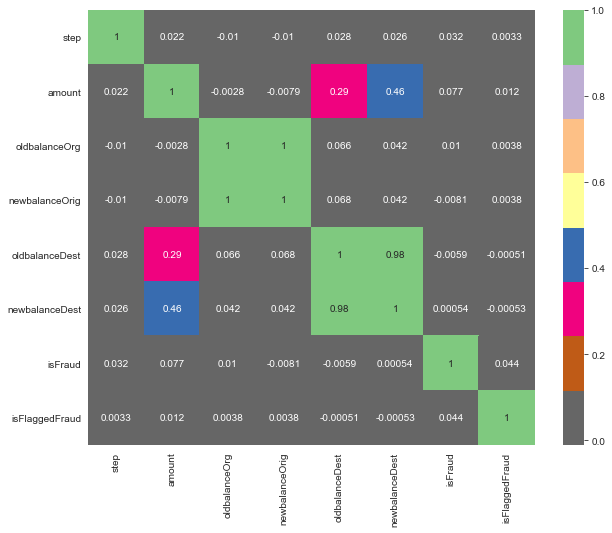

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='Accent_r')
plt.show()

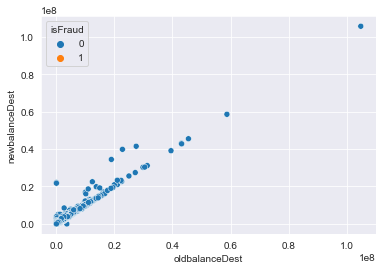

In [17]:
data = df.sample(5000)
sns.scatterplot(data.oldbalanceDest, data.newbalanceDest, hue=data.isFraud)
plt.show()

### Datasets with respect to Transaction types

#### CASH IN 

In [18]:
cash_in = df[df['type'] == 'CASH_IN']
console.print(f"[bold]Size:[/] {cash_in.size:,}")
cash_in.head()

Size: 15,392,124

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
389,1,CASH_IN,143236.26,C1862994526,0.00,143236.26,C1688019098,608932.17,97263.78,0,0
390,1,CASH_IN,228451.89,C1614133563,143236.26,371688.15,C2083562754,719678.38,1186556.81,0,0
391,1,CASH_IN,35902.49,C839771540,371688.15,407590.65,C2001112025,49003.30,0.00,0,0
392,1,CASH_IN,232953.64,C1037163664,407590.65,640544.28,C33524623,1172672.27,1517262.16,0,0
393,1,CASH_IN,65912.95,C180316302,640544.28,706457.23,C1330106945,104198.26,24044.18,0,0


#### DEBIT

In [19]:
debit = df[df['type'] == 'DEBIT']
console.print(f"[bold]Size:[/] {debit.size:,}")
debit.head()

Size: 455,752

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
21,1,DEBIT,9302.79,C1566511282,11299.0,1996.21,C1973538135,29832.0,16896.70,0,0
22,1,DEBIT,1065.41,C1959239586,1817.0,751.59,C515132998,10330.0,0.00,0,0
41,1,DEBIT,5758.59,C1466917878,32604.0,26845.41,C1297685781,209699.0,16997.22,0,0


#### PAYMENT

In [20]:
payment = df[df['type'] == 'PAYMENT']
console.print(f"[bold]Size:[/] {payment.size:,}")
payment.head()

Size: 23,666,445

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


#### CASH OUT

In [21]:
cash_out = df[df['type'] == 'CASH_OUT']
console.print(f"[bold]Size:[/] {cash_out.size:,}")
cash_out.head()

Size: 24,612,500

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0


#### TRANSFER

In [22]:
transfer = df[df['type'] == 'TRANSFER']
console.print(f"[bold]Size:[/] {transfer.size:,}")
transfer.head()

Size: 5,861,999

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0


In [23]:
console.print('Fraudulent transaction in CASH OUT transaction type', style='bold underline bright_red')
console.print(cash_out['isFraud'].value_counts(), style='bold bright_black')
console.print('Fraudulent transaction in TRANSFER transaction type', style='bold underline bright_red')
console.print(transfer['isFraud'].value_counts(), style='bold  bright_black')

Fraudulent transaction in CASH OUT transaction type

0    2233384
1       4116
Name: isFraud, dtype: int64

Fraudulent transaction in TRANSFER transaction type

0    528812
1      4097
Name: isFraud, dtype: int64

### Fraudulent dataset

In [24]:
f_df = df[df["isFraud"] == 1]
console.print(f'Shape: {f_df.shape}', style='bold')
f_df.head()

Shape: (8213, 11)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


type      isFlaggedFraud
CASH_OUT  0                 4116
TRANSFER  0                 4081
          1                   16
Name: isFlaggedFraud, dtype: int64

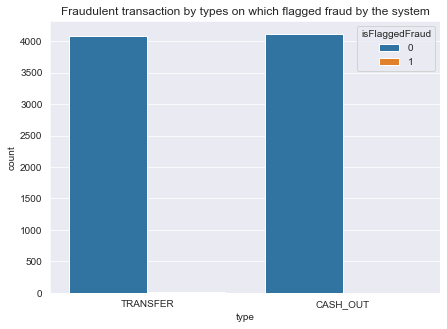

In [25]:
console.print(f_df.groupby(['type', 'isFlaggedFraud'])['isFlaggedFraud'].count(), style='bold')
plt.figure(figsize=(7, 5))
sns.countplot('type', data=f_df, hue="isFlaggedFraud")
plt.title("Fraudulent transaction by types on which flagged fraud by the system")
plt.show()

The computer has flagged just 16 transaction as Fraud in the 'TRANSFER' category.

## Feature Engineering
Since the dataset is very big we are taking the 'CASH_OUT' and 'TRANSFER' type for the model buildling. Since these type has only has most fraudulent transaction. We will be adding relevant features to make the model more reliable.

In [26]:
df_f = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_f.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [27]:
df_f = df_f[(df_f['type'] == "CASH_OUT") | (df_f['type'] == "TRANSFER")]
console.print(f"Total Records: {df_f.shape[0]:,}", style="bold bright_black")
df_f.head()

Total Records: 2,770,409

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [28]:
fraud_count = df_f.groupby(['type', 'isFraud'])['isFraud'].count()
console.print(fraud_count, style='bold bright_black')

type      isFraud
CASH_OUT  0          2233384
          1             4116
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

### Taking note of the balances before and after transactions

As most of the transactions shows error in before and after transactions, we calculate the error

In [29]:
wrong_orig_bal = sum(df["oldbalanceOrg"] - df["amount"] != df["newbalanceOrig"])
wrong_dest_bal = sum(df["newbalanceDest"] + df["amount"] != df["newbalanceDest"])
console.print("Percentage of observations with balance errors in the account giving money: ",
              100*round(wrong_orig_bal/len(df),2), style='bold bright_red')
console.print("Percentage of observations with balance errors in the account receiving money: ",
              100*round(wrong_dest_bal/len(df),2), style='bold bright_red')

Percentage of observations with balance errors in the account giving money:  85.0

Percentage of observations with balance errors in the account receiving money:  100.0

In [50]:
# adding features "errorBalanceOrg" and "errorBalanceDest"
df_new = df_f.copy(deep=True)
df_new["errorBalanceOrg"] = df_new.newbalanceOrig + df_new.amount - df_new.oldbalanceOrg
df_new["errorBalanceDest"] = df_new.oldbalanceDest + df_new.amount - df_new.newbalanceDest
df_new.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0


In [31]:
fraud = df_new[df_new['isFraud'] == 1]
valid = df_new[df_new['isFraud'] == 0]

In [32]:
console.print("Proportion of fraudulent transactions with errorBalanceDest > 0: ",
              len(fraud[fraud.errorBalanceDest > 0])/len(fraud) * 100, style='bold bright_black')
console.print("Proportion of valid transactions with errorBalanceDest > 0: ",
      len(valid[valid.errorBalanceDest > 0])/len(valid) * 100, style='bold bright_black')
console.print("Proportion of fraudulent transactions with errorBalanceOrg > 0: ",
      len(fraud[fraud.errorBalanceOrg > 0])/len(fraud) * 100, style='bold bright_black')
console.print("Proportion of valid transactions with errorBalanceOrg > 0: ",
      len(valid[valid.errorBalanceOrg > 0])/len(valid) * 100, style='bold bright_black')

Proportion of fraudulent transactions with errorBalanceDest > 0:  57.128941921344214

Proportion of valid transactions with errorBalanceDest > 0:  19.744942067832984

Proportion of fraudulent transactions with errorBalanceOrg > 0:  0.633142578838427

Proportion of valid transactions with errorBalanceOrg > 0:  90.67180605576142

Conclusions:
1. Most of the transactions where errorbalanceDest > 0 has high chance of being fraud
2. Valid transactions are most likely to have errorbalanceOrig > 0 

### Step feature in the dataset

step - maps a unit of time in the real world. For example 1 step is 1 hour of time. Total steps 744 (30 days simulation).

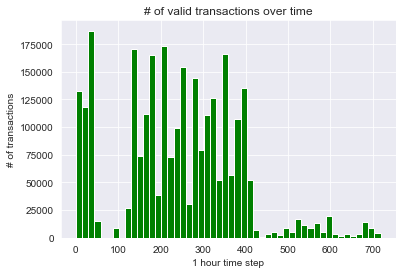

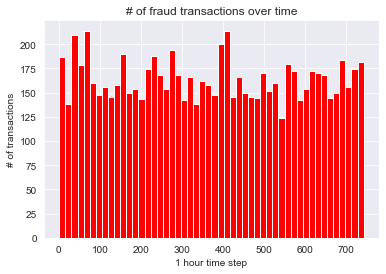

In [33]:
bins = 50
valid.hist(column="step", color="green", bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step", color="red", bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.show()

1. A lot of Valid transactions occur during 0 to 60 hours and then again 120 to 400 hrs
2. The fraud transactions dont change much throughout the time frame

In [34]:
num_days = 7
num_hours = 24
fraud_days = fraud.step % num_days
fraud_hours = fraud.step % num_hours
valid_days = valid.step % num_days
valid_hours = valid.step % num_hours

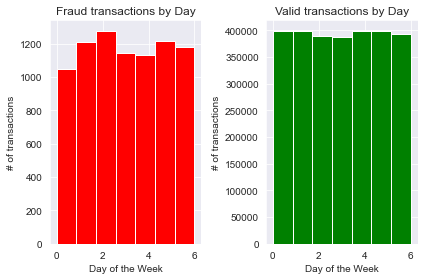

In [35]:
# plotting scatterplot of the days of the week
plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

The distribution of valid and fraud transaction in days didn't show much difference, this won't be added as a feature.

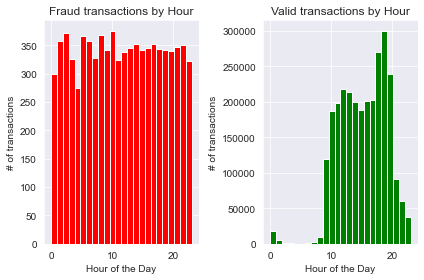

In [36]:
# plotting scatterplot of the hours of the week
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

There is strong evidence that transaction in valid by hour occur rarely in between 0 - 9 hours. So this will be added as a feature to our model building

In [37]:
dataset = df_new.copy(deep=True)
# adding feature hourOfTheDay in dataset
dataset["hourOfTheDay"] = dataset["step"] % 24
dataset.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,hourOfTheDay
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1


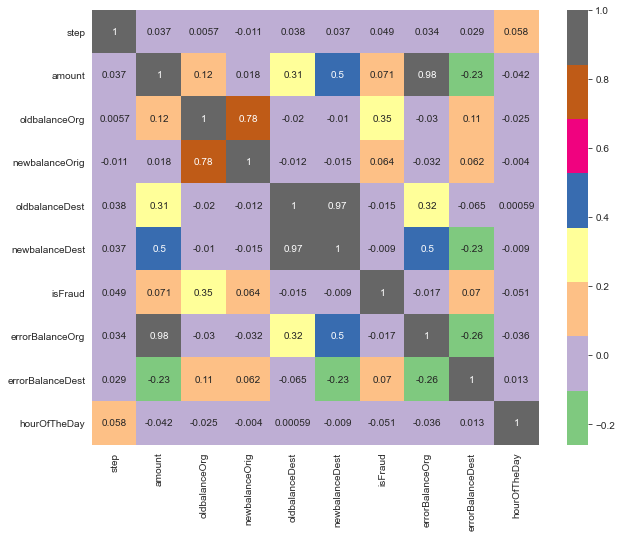

In [38]:
dataset_corr = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(dataset_corr, annot=True, cmap='Accent')
plt.show()

## Model Building

### Handling Categorical Variables

1) We will be using get_dummies method on 'type' variable, since it is a categorical feature

2) get_dummies method creating additional variable which are the values present in the categorical column

3) The indicator associated with the variable will be 1 and if it isn't part of the particular category, then indicator variable associated with the variable will be 0.

In [39]:
dataset = pd.get_dummies(dataset, prefix='type')

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,hourOfTheDay,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1,0,1


In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   amount            float64
 2   oldbalanceOrg     float64
 3   newbalanceOrig    float64
 4   oldbalanceDest    float64
 5   newbalanceDest    float64
 6   isFraud           int64  
 7   errorBalanceOrg   float64
 8   errorBalanceDest  float64
 9   hourOfTheDay      int64  
 10  type_CASH_OUT     uint8  
 11  type_TRANSFER     uint8  
dtypes: float64(7), int64(3), uint8(2)
memory usage: 237.8 MB


### Splitting into Train and Test dataset

In [41]:
X_ind = dataset.drop('isFraud', axis=1) #independent data

y_dep = dataset['isFraud'] # dependent data

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_ind, y_dep, test_size=0.2, random_state=2)

#Scaling all the independent variables in to 0 - 1
scaler = StandardScaler()

#fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [42]:
console.print(f"Shape of X_train: { X_train.shape}", style="bold bright_black")
console.print(f"Shape of X_test: {X_test.shape}", style="bold bright_black")

Shape of X_train: (2216327, 11)

Shape of X_test: (554082, 11)

## Model Selection

Consider the nature of our dataset in which the number of fraud and valid transaction is extremely skewed, we need to balance the dataset. First we will try out be using the imbalanced dataset for model building. For model buidling we will be using Random Forest and then we will balance the dataset and repeat the same training process.

### Random Forest Model (Imbalanced dataset)

In [43]:
# Train model
parametersRF = {'n_estimators':15,'class_weight': "balanced",'n_jobs':-1,'random_state':2}
RF_IbD = RandomForestClassifier(**parametersRF)
RF_IbD.fit(X_train, y_train)

#Prediction
predictionRF_IbD = RF_IbD.predict(X_test)

#Key performance Indicators
CM_RF_IbD = confusion_matrix(y_test, predictionRF_IbD)
CR_RF_IbD = classification_report(y_test, predictionRF_IbD)
fprRF_IbD, recallRF_IbD, thresholdsRF_IbD = roc_curve(y_test, predictionRF_IbD)
AUC_RF_IbD = auc(fprRF_IbD, recallRF_IbD)

In [44]:
def show_KPI(ConfMatrix, ClassReport, AreaUC, model):
    console.print(model, style='bold underline black')
    print()
    console.print('Confusion Matrix:', style='bold black')
    console.print(ConfMatrix, style='bold bright_black')
    print()
    console.print('Classification Report:', style='bold black')
    console.print(ClassReport, style='bold bright_black')
    print()
    console.print(f"Area Under Curve: {AreaUC}", style='bold black')


show_KPI(CM_RF_IbD, CR_RF_IbD, AUC_RF_IbD, 'Random Forest using Imbalanced Dataset')

Random Forest using Imbalanced Dataset

Confusion Matrix:

[[548650   3810]
 [   501   1121]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552460
           1       0.23      0.69      0.34      1622

    accuracy                           0.99    554082
   macro avg       0.61      0.84      0.67    554082
weighted avg       1.00      0.99      0.99    554082

Area Under Curve: 0.8421128223130057

### Handling Balanced Data

In [45]:
RUS = RandomUnderSampler(random_state=2)

X_resampled, y_resampled = RUS.fit_resample(X_ind, y_dep)
console.print('Resampled shape of X_ind:', X_resampled.shape, style='bold bright_black')
console.print('Resampled shape of y_dep:', y_resampled.shape, style='bold bright_black')

value_counts = Counter(y_resampled)
console.print('Count of valid and fraudulent transaction:', value_counts, style='bold bright_black')

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.8, random_state=2)

#Scaling all the independent variables in to 0 - 1
scaler = StandardScaler()

#fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Resampled shape of X_ind:
(16426, 11)

Resampled shape of y_dep:
(16426,)

Count of valid and fraudulent transaction:
Counter({0: 8213, 1: 8213})

### Random Forest Model (Balanced dataset)

In [46]:
# Train model
parametersRF = {'n_estimators':15,'class_weight': "balanced",'n_jobs':-1,'random_state':2}
RF_BD = RandomForestClassifier(**parametersRF)
RF_BD.fit(X_train, y_train)

#Prediction
predictionRF_BD = RF_BD.predict(X_test)

#Key performance Indicators
CM_RF_BD = confusion_matrix(y_test, predictionRF_BD)
CR_RF_BD = classification_report(y_test, predictionRF_BD)
fprRF_BD, recallRF_BD, thresholdsRF_BD = roc_curve(y_test, predictionRF_BD)
AUC_RF_BD = auc(fprRF_BD, recallRF_BD)


In [47]:
show_KPI(CM_RF_BD, CR_RF_BD, AUC_RF_BD, 'Random Forest using Balanced Dataset')

Random Forest using Balanced Dataset

Confusion Matrix:

[[1370  261]
 [   5 1650]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1631
           1       0.86      1.00      0.93      1655

    accuracy                           0.92      3286
   macro avg       0.93      0.92      0.92      3286
weighted avg       0.93      0.92      0.92      3286

Area Under Curve: 0.9184771635661771

### Comparing Both models

In [48]:
console.print('Random Forest Imbalanced Dataset', style='bold underline')
console.print("Confusion Matrix:", style='bold bright_black')
console.print(CM_RF_IbD, style='bold bright_black')
console.print("Area under curve: {}".format(AUC_RF_IbD), style='bold bright_black')
print()
console.print('Random Forest Balanced Dataset', style='bold underline')
console.print("Confusion Matrix:", style='bold bright_black')
console.print(CM_RF_BD, style='bold bright_black')
console.print("Area under curve: {}".format(AUC_RF_BD), style='bold bright_black')

Random Forest Imbalanced Dataset

Confusion Matrix:

[[548650   3810]
 [   501   1121]]

Area under curve: 0.8421128223130057

Random Forest Balanced Dataset

Confusion Matrix:

[[1370  261]
 [   5 1650]]

Area under curve: 0.9184771635661771

What does the Area under Curve tells us ?
Area Under Curve is a plot of the true positive rates (in our case, the proportion of valid transactions labelled as valid) against the false positive rate (in our case, the proportion of fraudulent transactions labelled as valid). The curve is also known as the Receiver Operating Characteristic Curve or ROC.

The ideal AUC is then 1 (all transactions predicted as valid are actually valid).

From the above results:
Random Forest with Balanced Dataset has the Area under Curve closest to 1, so I can confidently say that Random forest is the right model in this scenario.

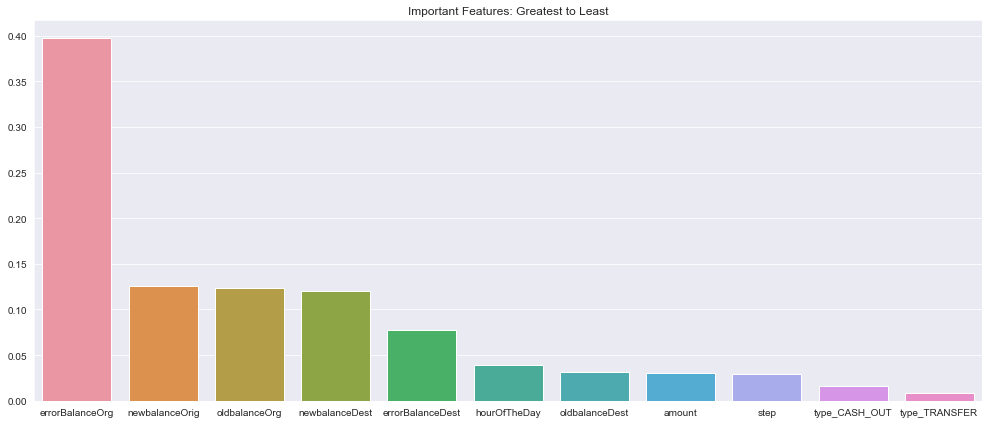

In [49]:
ncols = len(X_ind.columns)
x = np.arange(ncols)
# getting importances of features
importances = RF_BD.feature_importances_
# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(17, 7))
sns.barplot(x, importances[sort_ind])
plt.xticks(x, tuple(X_ind.columns.values[sort_ind]))
plt.title("Important Features: Greatest to Least")
plt.show()

    'errorBalanceOrg' by far the important feature for classifying fraudulent transaction followed by 'newbalanceOrig' and 'oldbalanceOrg'

## Conclusion:

1) The dataset has over 63 lakh datapoints, so the ratio of valid and fraudulent transaction is heavily skewed towards valid transaction.

2) Feature engineering and creation of two variables namely 'errorBalanceOrg' and 'hourOfTheDay' yielded helpful result.

3) We have compared both the Random Forest using unbalanced and balanced dataset.

4) Since our data is heavily skewed, the dataset is balanced using under sampling method.

5) After analyzing the results the Area Under Curve is high for balanced dataset, still the there is some valid transaction is labelled  as fraud.